# Deep Neural Networks Laboration

Data used in this laboration are from the Kitsune Network Attack Dataset, https://archive.ics.uci.edu/ml/datasets/Kitsune+Network+Attack+Dataset . We will focus on the 'Mirai' part of the dataset. Your task is to make a DNN that can classify if each attack is benign or malicious. The dataset has 116 covariates, but to make it a bit more difficult we will remove the first 24 covariates.

You need to answer all questions in this notebook.

If the training is too slow on your own computer, use the smaller datasets (*half or *quarter).

Dense networks are not optimal for tabular datasets like the one used here, but here the main goal is to learn deep learning.

# Part 1: Get the data

Skip this part if you load stored numpy arrays (Mirai*.npy) (which is recommended)

Use `wget` in the terminal of your cloud machine (in the same directory as where you have saved this notebook) to download the data, i.e.

wget https://archive.ics.uci.edu/ml/machine-learning-databases/00516/mirai/Mirai_dataset.csv.gz

wget https://archive.ics.uci.edu/ml/machine-learning-databases/00516/mirai/Mirai_labels.csv.gz

Then unpack the files using `gunzip` in the terminal, i.e.

gunzip Mirai_dataset.csv.gz

gunzip Mirai_labels.csv.gz

# Part 2: Get a graphics card

Skip this part if you run on the CPU (recommended)

Lets make sure that our script can see the graphics card that will be used. The graphics cards will perform all the time consuming calculations in every training iteration.

In [2]:
import os
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras.backend as K
import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";

# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
from google.colab import drive # connecting to drive to use be able to use the py programs and load the data
drive.mount('/gdrive')
%cd /gdrive/MyDrive/Deep\ learning/DL-Liu/Lab1

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1a_6Hhp5g_tVtFshcZqdwuTxdbOMBgn0u/DL-Liu/Lab1


# Part 3: Hardware

In deep learning, the computer hardware is very important. You should always know what kind of hardware you are working on. Lets pretend that everyone is using an Nvidia RTX 3090 graphics card.

Question 1: Google the name of the graphics card, how many CUDA cores does it have?

Question 2: How much memory does the graphics card have?

Question 3: What is stored in the GPU memory while training a DNN ?

# Answers

**Question 1**

10496 CUDA cores

**Question 2**

24 GB

**Question 3**

Parameters as weights and biases

Current batch of input data

Intermediate results during forward pass

Gradients during back propagation

Optimizers states as momentum, learning rate etc.

Results of activation function on the forward pass


# Part 4: Load the data

To make this step easier, directly load the data from saved numpy arrays (.npy) (recommended)


Load the dataset from the csv files, it will take some time since it is almost 1.4 GB. (not recommended, unless you want to learn how to do it)

We will use the function `genfromtxt` to load the data. (not recommended, unless you want to learn how to do it)

https://docs.scipy.org/doc/numpy/reference/generated/numpy.genfromtxt.html

Load the data from csv files the first time, then save the data as numpy files for faster loading the next time.

Remove the first 24 covariates to make the task harder.

In [4]:
from numpy import genfromtxt # Not needed if you load data from numpy arrays
import numpy as np

# Load data from numpy arrays, choose reduced files if the training takes too long
X = np.load('Mirai_data.npy')
Y = np.load('Mirai_labels.npy')



# Remove the first 24 covariates (columns)

X = X[:,24::]

print('The covariates have size {}.'.format(X.shape))
print('The labels have size {}.'.format(Y.shape))

# Print the number of examples of each class


The covariates have size (764137, 92).
The labels have size (764137,).


# Part 5: How good is a naive classifier?

Question 4: Given the number of examples from each class, how high classification performance can a naive classifier obtain? The naive classifier will assume that all examples belong to one class. Note: you do not need to make a naive classifier, this is a theoretical question, just to understand how good performance we can obtain by guessing that all examples belong to one class.

In all classification tasks you should always ask these questions

- How good classification accuracy can a naive classifier obtain? The naive classifier will assume that all examples belong to one class.
- What is random chance classification accuracy if you randomly guess the label of each (test) example? For a balanced dataset and binary classification this is easy (50%), but in many cases it is more complicated and a Monte Carlo simulation may be required to estimate random chance accuracy.

If your classifier cannot perform better than a naive classifier or a random classifier, you are doing something wrong.


**Question 4**

The accuracy of a naive classifier will be the proportion of the largest class in the dataset.


In [5]:
# It is common to have NaNs in the data, lets check for it. Hint: np.isnan()

print('Nr of NaNs in the data')
print(np.sum(np.isnan(X)))

# Print the number of NaNs (not a number) in the labels
print('Nr of NaNs in the labels')
print(np.sum(np.isnan(Y)))

# Print the number of NaNs in the covariates
print('Nr of NaNs in the covariates')

call = 1
for i in range(0,X.shape[1]):
  if np.sum(np.isnan(X[:,i])) > 0:
    print(f'Number of NaNs in covariate {i}')
    print(np.sum(np.isnan(X[:,i])))
    call+= 1
if call == 1:
  print(f'All {X.shape[1]} covariates have 0 NaNs')


Nr of NaNs in the data
0
Nr of NaNs in the labels
0
Nr of NaNs in the covariates
All 92 covariates have 0 NaNs


# Part 6: Preprocessing

Lets do some simple preprocessing

In [6]:
# Convert covariates to floats
X = X.astype('float')

# Convert labels to integers

Y = Y.astype('int')

# Remove mean of each covariate (column)
for col in range(0,X.shape[1]):
  mean = np.mean(X[:,col])
  X[:,col] = X[:,col] - mean

# Divide each covariate (column) by its standard deviation
for col in range(0,X.shape[1]):
  sd = np.std(X[:,col])
  X[:,col] = X[:,col] / sd

# Check that mean is 0 and standard deviation is 1 for all covariates, by printing mean and std
print(np.mean(X))
print(np.std(X))

4.779698048411524e-18
0.9999999999999997


# Part 7: Split the dataset

Use the first 70% of the dataset for training, leave the other 30% for validation and test, call the variables

Xtrain (70%)

Xtemp  (30%)

Ytrain (70%)

Ytemp  (30%)

We use a function from scikit learn.
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html


In [7]:
from sklearn.model_selection import train_test_split

# Your code to split the dataset
Xtrain,Xtemp,Ytrain,Ytemp = train_test_split(X,Y,test_size=0.3)

print('Xtrain has size {}.'.format(Xtrain.shape))
print('Ytrain has size {}.'.format(Ytrain.shape))

print('Xtemp has size {}.'.format(Xtemp.shape))
print('Ytemp has size {}.'.format(Ytemp.shape))

# Print the number of examples of each class, for the training data and the remaining 30%

print(np.bincount(Ytrain))
print(np.bincount(Ytemp))

Xtrain has size (534895, 92).
Ytrain has size (534895,).
Xtemp has size (229242, 92).
Ytemp has size (229242,).
[ 85247 449648]
[ 36374 192868]


In [8]:
np.bincount(Ytrain)[1] / sum(np.bincount(Ytrain)) # to see the naive accuracy on train data

0.8406285345722058

#  Part 8: Split non-training data data into validation and test
Now split your non-training data (Xtemp, Ytemp) into 50% validation (Xval, Yval) and 50% testing (Xtest, Ytest), we use a function from scikit learn. In total this gives us 70% for training, 15% for validation, 15% for test.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

Do all variables (Xtrain,Ytrain), (Xval,Yval), (Xtest,Ytest) have the shape that you expect?

In [9]:
from sklearn.model_selection import train_test_split

# Your code
Xval,Xtest,Yval,Ytest = train_test_split(Xtemp,Ytemp,test_size=0.5)

print('The validation and test data have size {}, {}, {} and {}'.format(Xval.shape, Xtest.shape, Yval.shape, Ytest.shape))

The validation and test data have size (114621, 92), (114621, 92), (114621,) and (114621,)


# Part 9: DNN classification

Finish this code to create a first version of the classifier using a DNN. Start with a simple network with 2 dense layers (with 20 nodes each), using sigmoid activation functions. The final dense layer should have a single node and a sigmoid activation function. We start with the SGD optimizer.

For different parts of this notebook you need to go back here, add more things, and re-run this cell to re-define the build function.

Relevant functions are

`model.add()`, adds a layer to the network

`Dense()`, a dense network layer

`model.compile()`, compile the model, add " metrics=['accuracy'] " to print the classification accuracy during the training

See https://keras.io/layers/core/ for information on how the `Dense()` function works

Import a relevant cost / loss function for binary classification from keras.losses (https://keras.io/losses/)

See the following links for how to compile, train and evaluate the model

https://keras.io/api/models/model_training_apis/#compile-method

https://keras.io/api/models/model_training_apis/#fit-method

https://keras.io/api/models/model_training_apis/#evaluate-method

Make sure that the last layer always has a sigmoid activation function (why?).


**Question 4.2**

We want to use the sigmoid activation on the last layer to get the output between 1 and 0, which is good for us as we have a binary classification problem and it can then be interpreted as probability.

In [10]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from keras.losses import binary_crossentropy as BC

# Set seed from random number generator, for better comparisons
from numpy.random import seed
seed(123)

def build_DNN(input_shape, n_layers, n_nodes, act_fun='sigmoid', optimizer='sgd', learning_rate=0.01,
              use_bn=False, use_dropout=False, use_custom_dropout=False):

    # Setup optimizer, depending on input parameter string

    # Setup a sequential model
    model = Sequential()

    # Add layers to the model, using the input parameters of the build_DNN function

    # Add first layer, requires input shape
    model.add(Dense(n_nodes,input_dim = input_shape, activation=act_fun))

    # Add remaining layers, do not require input shape
    for i in range(n_layers-1):
        model.add(Dense(n_nodes, activation=act_fun))

        if use_bn:
          model.add(BatchNormalization())
        if use_dropout:
          model.add(Dropout(0.5))
        if use_custom_dropout:
          model.add(myDropout(0.5))

    # Add final layer
    model.add(Dense(1,activation='sigmoid'))



    if optimizer.lower() == 'sgd':
      optimizer = SGD(learning_rate=learning_rate)
    elif optimizer.lower() == 'adam':
      optimizer = Adam(learning_rate=learning_rate)
    # Compile model
    model.compile(loss=BC, optimizer=optimizer,metrics=['accuracy'])

    return model

In [11]:
# Lets define a help function for plotting the training results

import matplotlib.pyplot as plt
def plot_results(history):

    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training','Validation'])

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training','Validation'])

    plt.show()

# Part 10: Train the DNN

Time to train the DNN, we start simple with 2 layers with 20 nodes each, learning rate 0.1.

Relevant functions

`build_DNN`, the function we defined in Part 9, call it with the parameters you want to use

`model.fit()`, train the model with some training data

`model.evaluate()`, apply the trained model to some test data

See the following links for how to train and evaluate the model

https://keras.io/api/models/model_training_apis/#fit-method

https://keras.io/api/models/model_training_apis/#evaluate-method


Make sure that you are using learning rate 0.1 !

### 2 layers, 20 nodes

In [ ]:
# Setup some training parameters
batch_size = 10000
epochs = 20

input_shape = Xtrain.shape[1]

# Build the model
model1 = build_DNN(input_shape,2,20, learning_rate=0.1)

# Train the model, provide training data and validation data
history1 = model1.fit(Xtrain, Ytrain,epochs =epochs, batch_size=batch_size,validation_data=(Xval,Yval))

Epoch 1/20
54/54 [==============================] - 2s 22ms/step - loss: 0.4873 - accuracy: 0.7774 - val_loss: 0.3998 - val_accuracy: 0.8408
Epoch 2/20
54/54 [==============================] - 1s 15ms/step - loss: 0.3808 - accuracy: 0.8411 - val_loss: 0.3595 - val_accuracy: 0.8408
Epoch 3/20
54/54 [==============================] - 1s 14ms/step - loss: 0.3359 - accuracy: 0.8411 - val_loss: 0.3108 - val_accuracy: 0.8408
Epoch 4/20
54/54 [==============================] - 1s 14ms/step - loss: 0.2881 - accuracy: 0.8411 - val_loss: 0.2662 - val_accuracy: 0.8408
Epoch 5/20
54/54 [==============================] - 1s 14ms/step - loss: 0.2499 - accuracy: 0.8491 - val_loss: 0.2354 - val_accuracy: 0.8562
Epoch 6/20
54/54 [==============================] - 1s 13ms/step - loss: 0.2257 - accuracy: 0.8616 - val_loss: 0.2172 - val_accuracy: 0.8735
Epoch 7/20
54/54 [==============================] - 1s 15ms/step - loss: 0.2115 - accuracy: 0.8799 - val_loss: 0.2065 - val_accuracy: 0.8877
Epoch 8/20
54

In [ ]:
# Evaluate the model on the test data
score = model1.evaluate(Xtest,Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 9s 2ms/step - loss: 0.1756 - accuracy: 0.9081
Test loss: 0.1756
Test accuracy: 0.9081


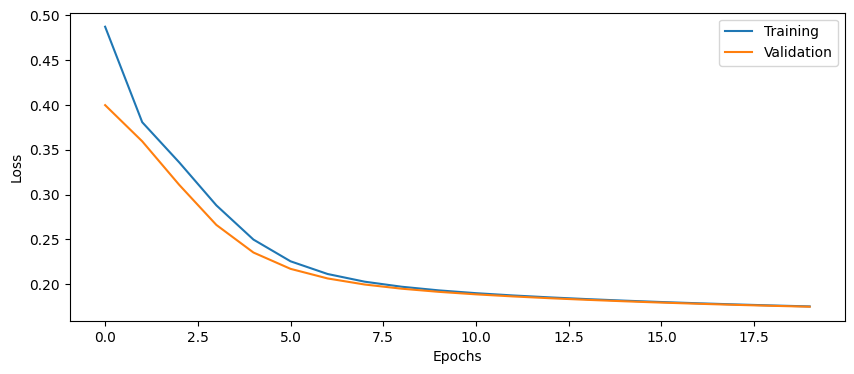

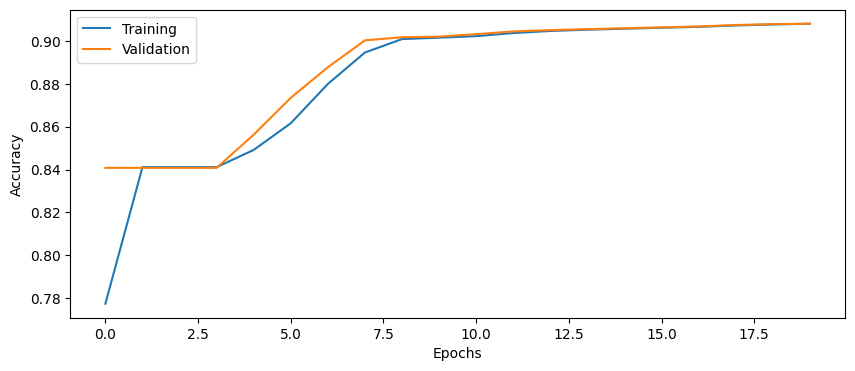

In [ ]:
# Plot the history from the training run
plot_results(history1)

The accuracy for the simple model is better than the naive accuracy and it doesnt look to have overfitted as the validation error decreases through all epochs. Should probably run more epochs until we overfit and then use early stopping to get a better model with this model architecture.

# Part 11: More questions

Question 5: What happens if you add several Dense layers without specifying the activation function?

Question 6: How are the weights in each dense layer initialized as default? How are the bias weights initialized?


**Question 5**

The added dense layers will have sigmoid as the activation function as its default for the act_fun argument in the function. Without that as default the dense layer will use a linear activation function.


**Question 6**

The biases are set to zero as default in the Dense layer, the weights are randomly drawn from a glorot uniform distrubution as its the default in Dense layers on Keras.


# Part 12: Balancing the classes

This dataset is rather unbalanced, we need to define class weights so that the training pays more attention to the class with fewer samples. We use a function in scikit learn

https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html

You need to call the function something like this

class_weights = class_weight.compute_class_weight(class_weight = , classes = , y = )

otherwise it will complain

In [12]:
from sklearn.utils import class_weight

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(Ytrain), y =Ytrain )

# calculations with formula used in function above
cw_byhand = len(Ytrain)/(2*np.bincount(Ytrain))

# Print the class weights
print(class_weights)
print(cw_byhand)
# Keras wants the weights in this form, uncomment and change value1 and value2 to your weights,
# or get them from the array that is returned from class_weight

class_weights = {0: class_weights[0],
                1: class_weights[1]}
class_weights

[3.13732448 0.59479304]
[3.13732448 0.59479304]


{0: 3.137324480626884, 1: 0.5947930381098103}

### 2 layers, 20 nodes, class weights

In [ ]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = X.shape[1]

# Build and train model
model2 = build_DNN(input_shape,2,20, learning_rate=0.1)

history2 = model2.fit(Xtrain, Ytrain,epochs =epochs, batch_size=batch_size,validation_data=(Xval,Yval), class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 2s 21ms/step - loss: 0.6546 - accuracy: 0.6540 - val_loss: 0.5915 - val_accuracy: 0.8861
Epoch 2/20
54/54 [==============================] - 1s 15ms/step - loss: 0.5090 - accuracy: 0.8850 - val_loss: 0.4381 - val_accuracy: 0.8834
Epoch 3/20
54/54 [==============================] - 1s 14ms/step - loss: 0.3543 - accuracy: 0.8824 - val_loss: 0.3294 - val_accuracy: 0.8824
Epoch 4/20
54/54 [==============================] - 1s 15ms/step - loss: 0.2728 - accuracy: 0.8826 - val_loss: 0.2919 - val_accuracy: 0.8835
Epoch 5/20
54/54 [==============================] - 1s 15ms/step - loss: 0.2411 - accuracy: 0.8846 - val_loss: 0.2778 - val_accuracy: 0.8858
Epoch 6/20
54/54 [==============================] - 1s 15ms/step - loss: 0.2267 - accuracy: 0.8874 - val_loss: 0.2696 - val_accuracy: 0.8888
Epoch 7/20
54/54 [==============================] - 1s 15ms/step - loss: 0.2185 - accuracy: 0.8897 - val_loss: 0.2641 - val_accuracy: 0.8904
Epoch 8/20
54

In [ ]:
# Evaluate model on test data
score = model2.evaluate(Xtest,Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 7s 2ms/step - loss: 0.2356 - accuracy: 0.8991
Test loss: 0.2356
Test accuracy: 0.8991


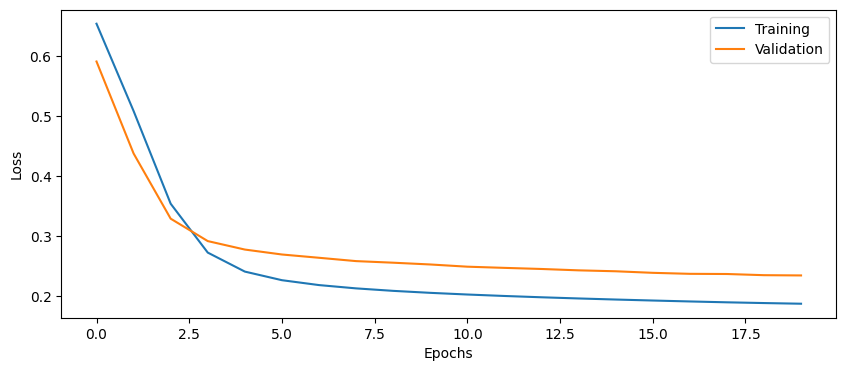

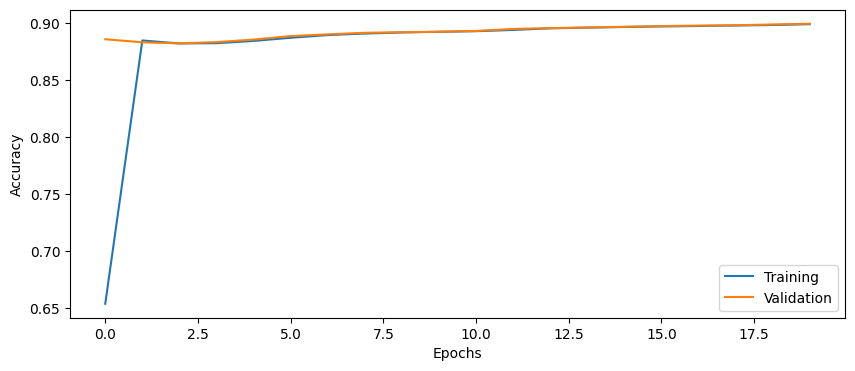

In [ ]:
plot_results(history2)

# Part 13: More questions

Skip questions 8 and 9 if you run on the CPU (recommended)

Question 7: Why do we have to use a batch size? Why can't we simply use all data at once? This is more relevant for even larger datasets.

Question 8: How busy is the GPU for a batch size of 100? How much GPU memory is used? Hint: run 'nvidia-smi' on the computer a few times during training.

Question 9: What is the processing time for one training epoch when the batch size is 100? What is the processing time for one epoch when the batch size is 1,000? What is the processing time for one epoch when the batch size is 10,000? Explain the results.

Question 10: How many times are the weights in the DNN updated in each training epoch if the batch size is 100? How many times are the weights in the DNN updated in each training epoch if the batch size is 1,000? How many times are the weights in the DNN updated in each training epoch if the batch size is 10,000?  

Question 11: What limits how large the batch size can be?

Question 12: Generally speaking, how is the learning rate related to the batch size? If the batch size is decreased, how should the learning rate be changed?

Lets use a batch size of 10,000 from now on, and a learning rate of 0.1.

In [ ]:
# calculating weight updates
total_samples = len(Ytrain)
for i in (100,1000,10000):
  num_batches = total_samples / i
  print(i,'=',num_batches)

100 = 5348.95
1000 = 534.895
10000 = 53.4895


**Q7**

We use batch size to reduce the memory usage so we dont have to use all the data for every iteration, it can also introduce some regularization to the training as we introducing some noise to the process.

**Q10**

Number of updates are printed from the for-loop above. (Below are ceiled numbers)
100 = 5349
1000 = 535
10000 = 54


**Q11**

The CPU or GPU memory can limit the batch size, as the larger batches the more data in each iteration. The size of your data also matter, as you cant choose a larger batch than the amount of data you have.


**Q12**

Larger batch size => greater learning rate as you are using more data and less noice.

Smaller batch size => more noice => lower learning rate to reduce the learning from noice, we dont want to update the weights to much with the noice.


# Part 14: Increasing the complexity

Lets try some different configurations of number of layers and number of nodes per layer.

Question 13: How many trainable parameters does the network with 4 dense layers with 50 nodes each have, compared to the initial network with 2 layers and 20 nodes per layer? Hint: use model.summary()

**Q13**

4 layer with 50 nodes = 12351 params

2 layers with 20 nodes = 2301 params

### 4 layers, 20 nodes, class weights

In [ ]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = X.shape[1]

# Build and train model
model3 = build_DNN(input_shape,4,20, learning_rate=0.1)

history3 = model3.fit(Xtrain, Ytrain,epochs =epochs, batch_size=batch_size,validation_data=(Xval,Yval), class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 4s 58ms/step - loss: 0.6996 - accuracy: 0.2650 - val_loss: 0.6954 - val_accuracy: 0.1588
Epoch 2/20
54/54 [==============================] - 2s 33ms/step - loss: 0.6921 - accuracy: 0.4986 - val_loss: 0.6898 - val_accuracy: 0.8491
Epoch 3/20
54/54 [==============================] - 2s 38ms/step - loss: 0.6918 - accuracy: 0.5461 - val_loss: 0.6940 - val_accuracy: 0.1585
Epoch 4/20
54/54 [==============================] - 2s 35ms/step - loss: 0.6913 - accuracy: 0.6450 - val_loss: 0.6889 - val_accuracy: 0.8602
Epoch 5/20
54/54 [==============================] - 2s 30ms/step - loss: 0.6909 - accuracy: 0.6227 - val_loss: 0.6948 - val_accuracy: 0.1595
Epoch 6/20
54/54 [==============================] - 2s 32ms/step - loss: 0.6903 - accuracy: 0.6615 - val_loss: 0.6917 - val_accuracy: 0.8682
Epoch 7/20
54/54 [==============================] - 2s 37ms/step - loss: 0.6897 - accuracy: 0.7213 - val_loss: 0.6873 - val_accuracy: 0.8894
Epoch 8/20
54

In [ ]:
# Evaluate model on test data
score = model3.evaluate(Xtest,Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 8s 2ms/step - loss: 0.5351 - accuracy: 0.8784
Test loss: 0.5351
Test accuracy: 0.8784


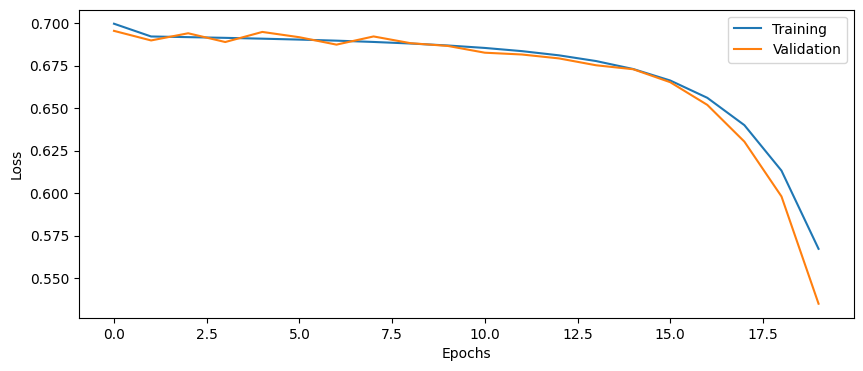

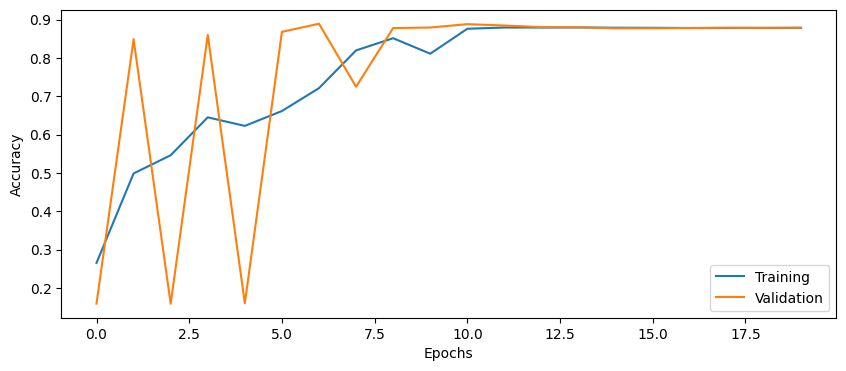

In [ ]:
plot_results(history3)

### 2 layers, 50 nodes, class weights

In [ ]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = X.shape[1]

# Build and train model
model4 = build_DNN(input_shape,2,50, learning_rate=0.1)

history4 = model4.fit(Xtrain, Ytrain,epochs =epochs, batch_size=batch_size,validation_data=(Xval,Yval), class_weight=class_weights)



Epoch 1/20
54/54 [==============================] - 2s 31ms/step - loss: 0.6248 - accuracy: 0.8708 - val_loss: 0.5166 - val_accuracy: 0.8791
Epoch 2/20
54/54 [==============================] - 1s 22ms/step - loss: 0.4148 - accuracy: 0.8805 - val_loss: 0.3439 - val_accuracy: 0.8807
Epoch 3/20
54/54 [==============================] - 1s 24ms/step - loss: 0.2804 - accuracy: 0.8807 - val_loss: 0.2887 - val_accuracy: 0.8808
Epoch 4/20
54/54 [==============================] - 1s 24ms/step - loss: 0.2378 - accuracy: 0.8810 - val_loss: 0.2723 - val_accuracy: 0.8812
Epoch 5/20
54/54 [==============================] - 1s 24ms/step - loss: 0.2228 - accuracy: 0.8828 - val_loss: 0.2647 - val_accuracy: 0.8854
Epoch 6/20
54/54 [==============================] - 3s 58ms/step - loss: 0.2151 - accuracy: 0.8869 - val_loss: 0.2596 - val_accuracy: 0.8884
Epoch 7/20
54/54 [==============================] - 3s 56ms/step - loss: 0.2101 - accuracy: 0.8898 - val_loss: 0.2553 - val_accuracy: 0.8922
Epoch 8/20
54

In [ ]:
# Evaluate model on test data
score = model4.evaluate(Xtest,Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 6s 2ms/step - loss: 0.2343 - accuracy: 0.9009
Test loss: 0.2343
Test accuracy: 0.9009


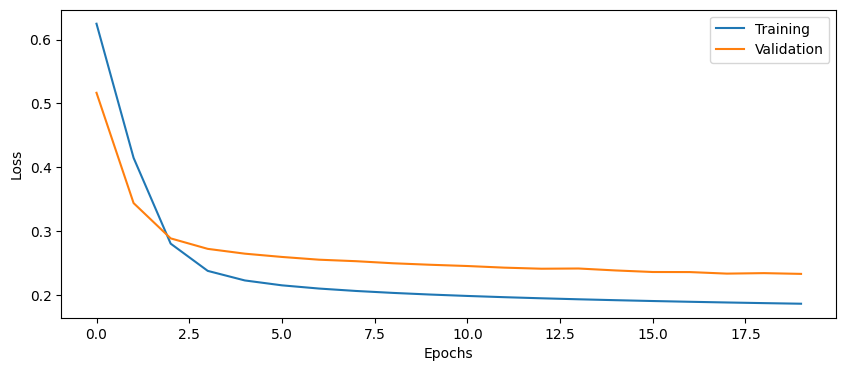

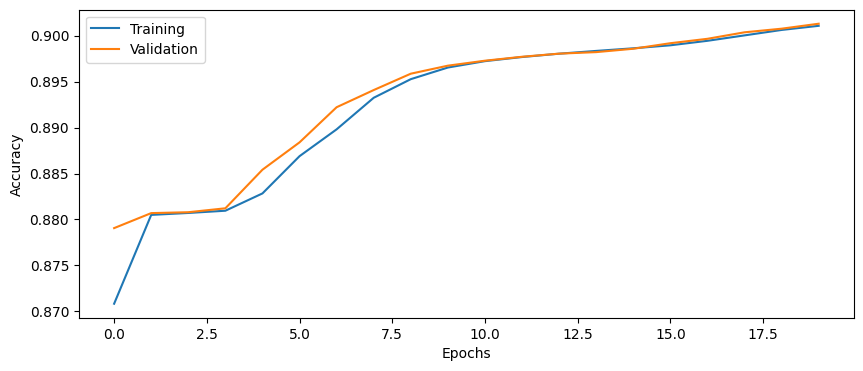

In [ ]:
plot_results(history4)

### 4 layers, 50 nodes, class weights

In [ ]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape =  X.shape[1]

# Build and train model
model5 = build_DNN(input_shape,4,50, learning_rate=0.1)

history5 = model5.fit(Xtrain, Ytrain,epochs =epochs, batch_size=batch_size,validation_data=(Xval,Yval), class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 3s 42ms/step - loss: 0.6941 - accuracy: 0.5598 - val_loss: 0.6983 - val_accuracy: 0.1593
Epoch 2/20
54/54 [==============================] - 2s 39ms/step - loss: 0.6926 - accuracy: 0.5179 - val_loss: 0.6920 - val_accuracy: 0.8839
Epoch 3/20
54/54 [==============================] - 3s 64ms/step - loss: 0.6916 - accuracy: 0.6023 - val_loss: 0.6910 - val_accuracy: 0.8883
Epoch 4/20
54/54 [==============================] - 2s 42ms/step - loss: 0.6906 - accuracy: 0.6419 - val_loss: 0.6852 - val_accuracy: 0.8444
Epoch 5/20
54/54 [==============================] - 2s 38ms/step - loss: 0.6894 - accuracy: 0.7406 - val_loss: 0.6858 - val_accuracy: 0.8790
Epoch 6/20
54/54 [==============================] - 2s 39ms/step - loss: 0.6879 - accuracy: 0.7683 - val_loss: 0.6821 - val_accuracy: 0.8607
Epoch 7/20
54/54 [==============================] - 2s 37ms/step - loss: 0.6859 - accuracy: 0.8609 - val_loss: 0.6837 - val_accuracy: 0.8871
Epoch 8/20
54

In [ ]:
# Evaluate model on test data
score = model5.evaluate(Xtest,Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 7s 2ms/step - loss: 0.2559 - accuracy: 0.8859
Test loss: 0.2559
Test accuracy: 0.8859


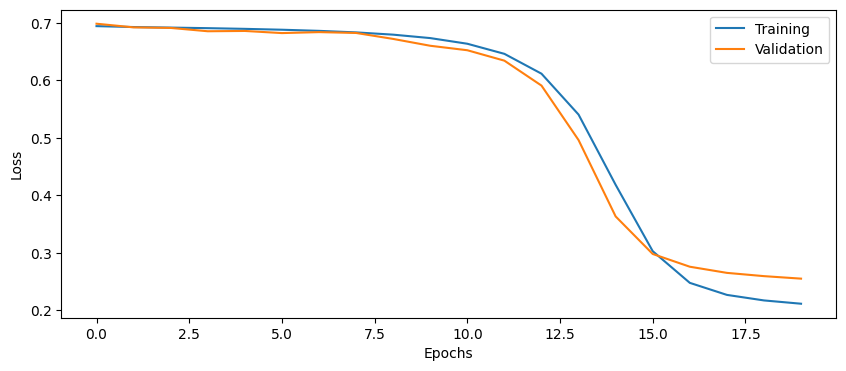

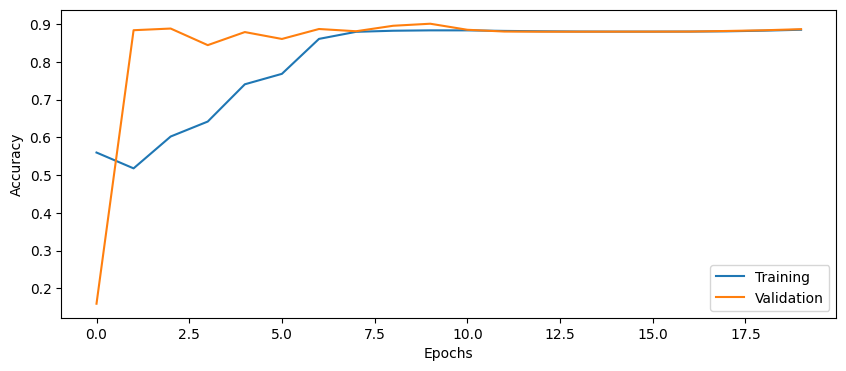

In [ ]:
plot_results(history5)

# Part 15: Batch normalization

Now add batch normalization after each dense layer in `build_DNN`. Remember to import BatchNormalization from keras.layers.

See https://keras.io/layers/normalization/ for information about how to call the function.

Question 14: Why is batch normalization important when training deep networks?

**Q14**

Batch normalization reduces the need for a careful initialization by reducing the sensetivity of the model to the initialized weights.

It will also reduces internal covariate shift, which simply mean the change of distribution of each layers inputs, this will make training more stable and faster.



### 2 layers, 20 nodes, class weights, batch normalization

In [ ]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = X.shape[1]

# Build and train model
model6 = build_DNN(input_shape,2,20, learning_rate=0.1, use_bn=True)

history6 = model6.fit(Xtrain, Ytrain,epochs =epochs, batch_size=batch_size,validation_data=(Xval,Yval), class_weight=class_weights)



Epoch 1/20
54/54 [==============================] - 3s 36ms/step - loss: 0.2888 - accuracy: 0.8826 - val_loss: 0.4138 - val_accuracy: 0.8408
Epoch 2/20
54/54 [==============================] - 1s 18ms/step - loss: 0.2187 - accuracy: 0.8979 - val_loss: 0.3742 - val_accuracy: 0.8408
Epoch 3/20
54/54 [==============================] - 1s 18ms/step - loss: 0.2006 - accuracy: 0.9037 - val_loss: 0.3611 - val_accuracy: 0.8408
Epoch 4/20
54/54 [==============================] - 1s 18ms/step - loss: 0.1919 - accuracy: 0.9076 - val_loss: 0.3464 - val_accuracy: 0.8408
Epoch 5/20
54/54 [==============================] - 1s 18ms/step - loss: 0.1867 - accuracy: 0.9099 - val_loss: 0.3233 - val_accuracy: 0.8408
Epoch 6/20
54/54 [==============================] - 1s 17ms/step - loss: 0.1832 - accuracy: 0.9111 - val_loss: 0.2941 - val_accuracy: 0.8408
Epoch 7/20
54/54 [==============================] - 1s 18ms/step - loss: 0.1806 - accuracy: 0.9119 - val_loss: 0.2570 - val_accuracy: 0.8408
Epoch 8/20
54

In [ ]:
# Evaluate model on test data
score = model6.evaluate(Xtest,Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 6s 2ms/step - loss: 0.2045 - accuracy: 0.9156
Test loss: 0.2045
Test accuracy: 0.9156


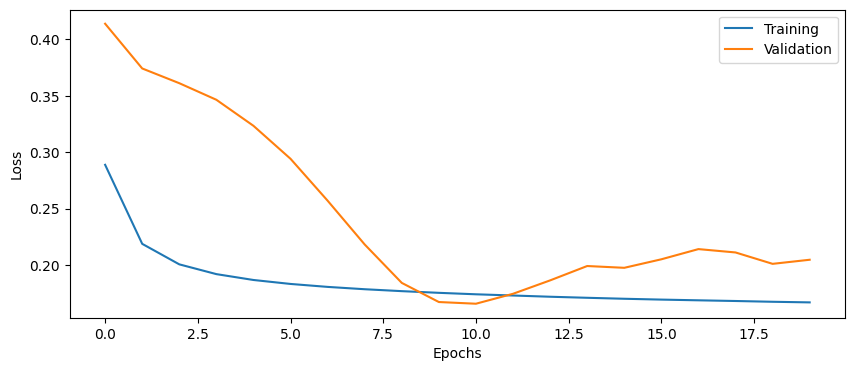

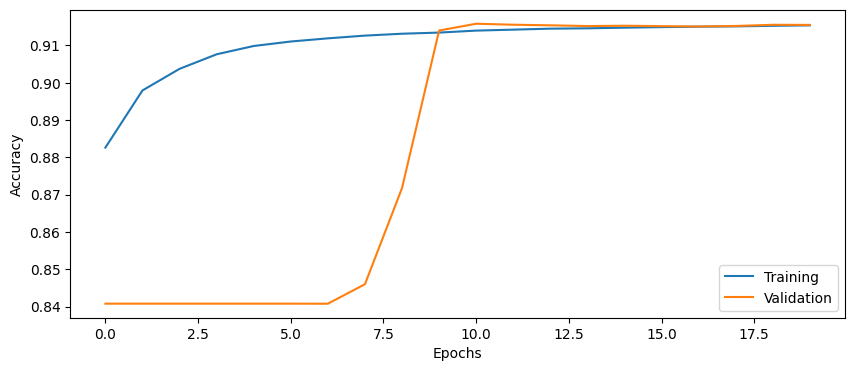

In [ ]:
plot_results(history6)

# Part 16: Activation function

Try changing the activation function in each layer from sigmoid to ReLU, write down the test accuracy.

Note: the last layer should still have a sigmoid activation function.

https://keras.io/api/layers/activations/

### 2 layers, 20 nodes, class weights, ReLU, no batch normalization

In [ ]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = X.shape[1]

# Build and train model
model7 = build_DNN(input_shape,2,20, learning_rate=0.1, act_fun='relu')

history7 =  model7.fit(Xtrain, Ytrain,epochs =epochs, batch_size=batch_size,validation_data=(Xval,Yval), class_weight=class_weights)


Epoch 1/20
54/54 [==============================] - 2s 19ms/step - loss: 0.3406 - accuracy: 0.8763 - val_loss: 0.2832 - val_accuracy: 0.8908
Epoch 2/20
54/54 [==============================] - 1s 13ms/step - loss: 0.2087 - accuracy: 0.8930 - val_loss: 0.2536 - val_accuracy: 0.8960
Epoch 3/20
54/54 [==============================] - 1s 14ms/step - loss: 0.1936 - accuracy: 0.8981 - val_loss: 0.2410 - val_accuracy: 0.8993
Epoch 4/20
54/54 [==============================] - 1s 13ms/step - loss: 0.1862 - accuracy: 0.9009 - val_loss: 0.2304 - val_accuracy: 0.9038
Epoch 5/20
54/54 [==============================] - 1s 12ms/step - loss: 0.1817 - accuracy: 0.9050 - val_loss: 0.2272 - val_accuracy: 0.9067
Epoch 6/20
54/54 [==============================] - 1s 13ms/step - loss: 0.1782 - accuracy: 0.9068 - val_loss: 0.2267 - val_accuracy: 0.9075
Epoch 7/20
54/54 [==============================] - 1s 14ms/step - loss: 0.1756 - accuracy: 0.9078 - val_loss: 0.2235 - val_accuracy: 0.9084
Epoch 8/20
54

In [ ]:
# Evaluate model on test data
score = model7.evaluate(Xtest,Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 6s 2ms/step - loss: 0.2063 - accuracy: 0.9161
Test loss: 0.2063
Test accuracy: 0.9161


The test accuracy for model 7 is 0.9161 which is the best of the models so far!

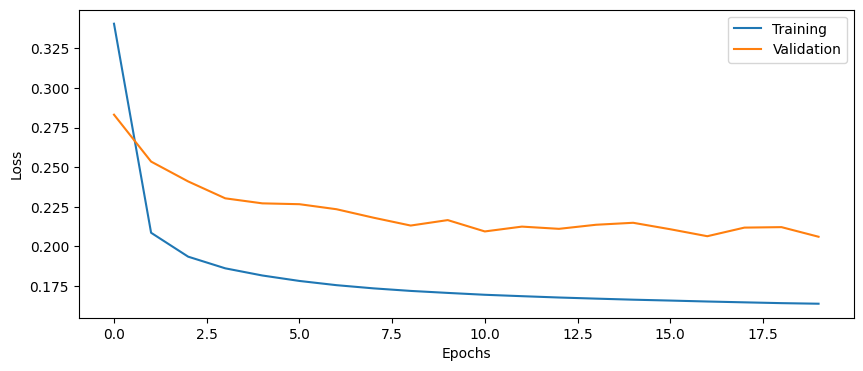

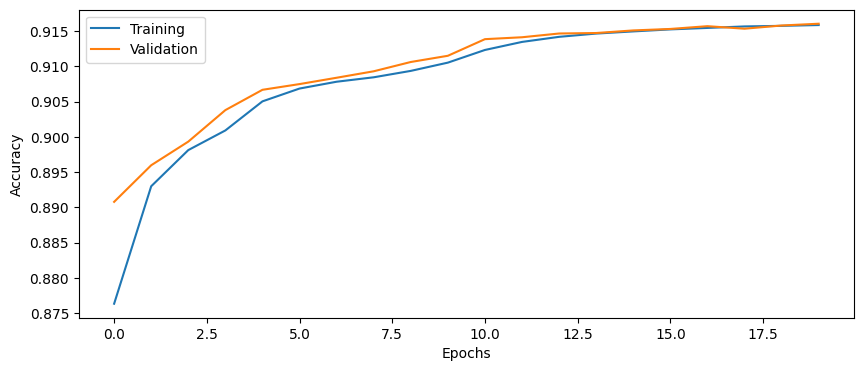

In [ ]:
plot_results(history7)

# Part 17: Optimizer

Try changing the optimizer from SGD to Adam (with learning rate 0.1 as before). Remember to import the Adam optimizer from keras.optimizers.

https://keras.io/optimizers/


### 2 layers, 20 nodes, class weights, Adam optimizer, no batch normalization, sigmoid activations

In [ ]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = X.shape[1]

# Build and train model
model8 = build_DNN(input_shape,2,20, learning_rate=0.1, optimizer='Adam')

history8 = model8.fit(Xtrain, Ytrain,epochs =epochs, batch_size=batch_size,validation_data=(Xval,Yval), class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 3s 31ms/step - loss: 0.2391 - accuracy: 0.8709 - val_loss: 0.2309 - val_accuracy: 0.9026
Epoch 2/20
54/54 [==============================] - 1s 24ms/step - loss: 0.1749 - accuracy: 0.9112 - val_loss: 0.2142 - val_accuracy: 0.9148
Epoch 3/20
54/54 [==============================] - 1s 18ms/step - loss: 0.1666 - accuracy: 0.9162 - val_loss: 0.2218 - val_accuracy: 0.9171
Epoch 4/20
54/54 [==============================] - 1s 15ms/step - loss: 0.1626 - accuracy: 0.9183 - val_loss: 0.2040 - val_accuracy: 0.9192
Epoch 5/20
54/54 [==============================] - 1s 14ms/step - loss: 0.1592 - accuracy: 0.9193 - val_loss: 0.2070 - val_accuracy: 0.9189
Epoch 6/20
54/54 [==============================] - 1s 15ms/step - loss: 0.1566 - accuracy: 0.9202 - val_loss: 0.1891 - val_accuracy: 0.9209
Epoch 7/20
54/54 [==============================] - 1s 13ms/step - loss: 0.1549 - accuracy: 0.9204 - val_loss: 0.2002 - val_accuracy: 0.9203
Epoch 8/20
54

In [ ]:
# Evaluate model on test data
score = model8.evaluate(Xtest,Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 6s 2ms/step - loss: 0.1763 - accuracy: 0.9307
Test loss: 0.1763
Test accuracy: 0.9307


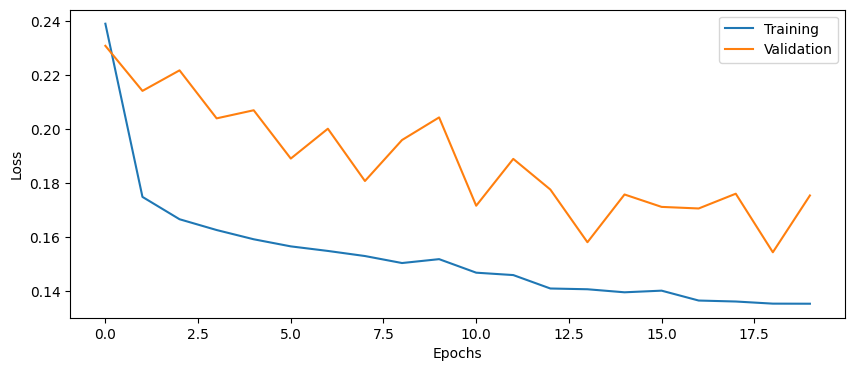

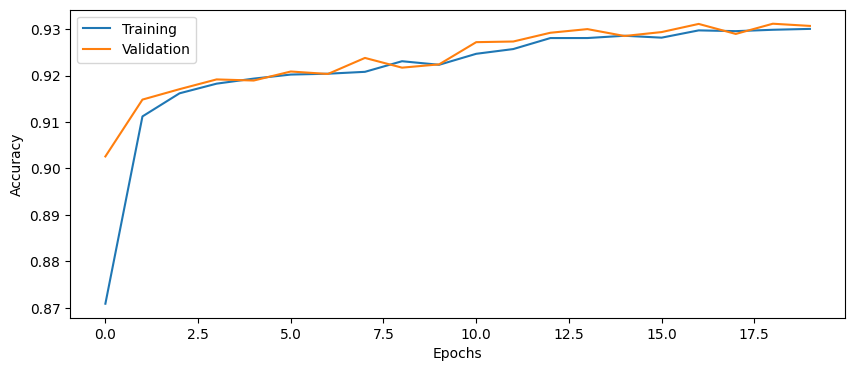

In [ ]:
plot_results(history8)

# Part 18: Dropout regularization

Dropout is a type of regularization that can improve accuracy for validation and test data. It randomly removes connections to force the neural network to not rely too much on a small number of weights.

Add a Dropout layer after each Dense layer (but not after the final dense layer) in `build_DNN`, with a dropout probability of 50%. Remember to first import the Dropout layer from keras.layers

See https://keras.io/api/layers/regularization_layers/dropout/ for how the Dropout layer works.

---

Question 15: How does the validation accuracy change when adding dropout?

Question 16: How does the test accuracy change when adding dropout?

**Q15**

We have a lower validation accuracy for the epoch with the lowest loss for this model compared to model2 which only differs by dropout. With more epochs this could change and the model with dropout could become better without to much overfitting.

**Q16**

If we are comparing to model2 which only differs by the dropout we get a little lower test accuracy on this model with dropout. In general we should get a higher test accuracy with dropout if it reduces overfitting, but thats not a problem for model2 with 20 epochs.


### 2 layers, 20 nodes, class weights, dropout, SGD optimizer, no batch normalization, sigmoid activations

In [ ]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = X.shape[1]

# Build and train model
model9 =  build_DNN(input_shape,2,20, learning_rate=0.1,use_dropout=True )

history9 = model9.fit(Xtrain, Ytrain,epochs =epochs, batch_size=batch_size,validation_data=(Xval,Yval), class_weight=class_weights)


Epoch 1/20
54/54 [==============================] - 2s 22ms/step - loss: 0.6907 - accuracy: 0.5891 - val_loss: 0.5927 - val_accuracy: 0.8914
Epoch 2/20
54/54 [==============================] - 1s 18ms/step - loss: 0.6045 - accuracy: 0.6796 - val_loss: 0.5044 - val_accuracy: 0.8845
Epoch 3/20
54/54 [==============================] - 1s 17ms/step - loss: 0.5095 - accuracy: 0.7606 - val_loss: 0.3934 - val_accuracy: 0.8832
Epoch 4/20
54/54 [==============================] - 1s 17ms/step - loss: 0.4176 - accuracy: 0.8156 - val_loss: 0.3187 - val_accuracy: 0.8816
Epoch 5/20
54/54 [==============================] - 1s 16ms/step - loss: 0.3536 - accuracy: 0.8455 - val_loss: 0.2819 - val_accuracy: 0.8814
Epoch 6/20
54/54 [==============================] - 1s 19ms/step - loss: 0.3165 - accuracy: 0.8603 - val_loss: 0.2685 - val_accuracy: 0.8815
Epoch 7/20
54/54 [==============================] - 2s 34ms/step - loss: 0.2940 - accuracy: 0.8679 - val_loss: 0.2606 - val_accuracy: 0.8825
Epoch 8/20
54

In [ ]:
# Evaluate model on test data
score = model9.evaluate(Xtest,Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 8s 2ms/step - loss: 0.2391 - accuracy: 0.8956
Test loss: 0.2391
Test accuracy: 0.8956


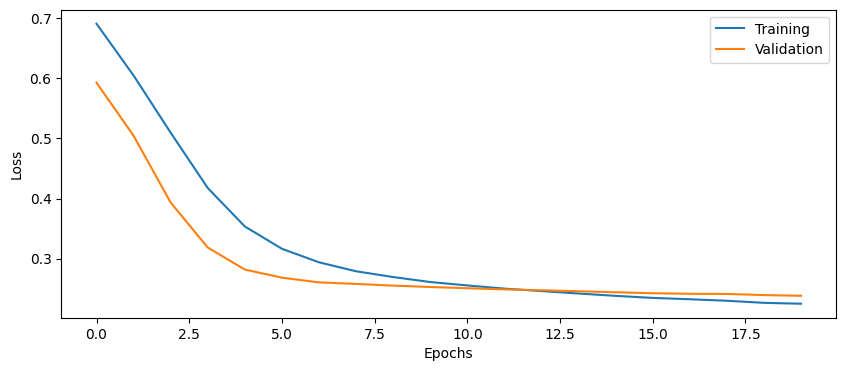

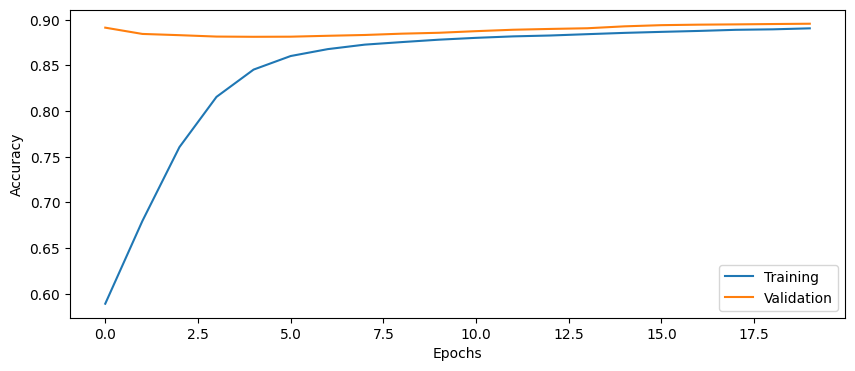

In [ ]:
plot_results(history9)

# Part 19: Improving performance

Spend some time (30 - 90 minutes) playing with the network architecture (number of layers, number of nodes per layer, activation function) and other hyper parameters (optimizer, learning rate, batch size, number of epochs, degree of regularization). For example, try a much deeper network. How much does the training time increase for a network with 10 layers?

Question 17: How high classification accuracy can you achieve for the test data? What is your best configuration?

In [ ]:
# Find your best configuration for the DNN
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor='val_loss', patience=15) # implement earlystopping

# Build and train DNN

input_shape = Xtrain.shape[1]
batch_size = 10000
epochs = 40

model10 = build_DNN(input_shape, n_layers = 3, n_nodes = 60,learning_rate=0.070, act_fun='relu', optimizer='Adam', use_bn=True)

history10 = model10.fit(Xtrain, Ytrain,epochs = epochs, batch_size=batch_size,validation_data=(Xval,Yval), class_weight=class_weights, callbacks = earlystop)


Epoch 1/40
54/54 [==============================] - 3s 14ms/step - loss: 0.2723 - accuracy: 0.8827 - val_loss: 0.9345 - val_accuracy: 0.8842
Epoch 2/40
54/54 [==============================] - 0s 9ms/step - loss: 0.1779 - accuracy: 0.9124 - val_loss: 0.3155 - val_accuracy: 0.9026
Epoch 3/40
54/54 [==============================] - 0s 9ms/step - loss: 0.1718 - accuracy: 0.9145 - val_loss: 0.2531 - val_accuracy: 0.9152
Epoch 4/40
54/54 [==============================] - 0s 9ms/step - loss: 0.1672 - accuracy: 0.9161 - val_loss: 0.1863 - val_accuracy: 0.9164
Epoch 5/40
54/54 [==============================] - 0s 9ms/step - loss: 0.1647 - accuracy: 0.9163 - val_loss: 0.1833 - val_accuracy: 0.9182
Epoch 6/40
54/54 [==============================] - 0s 8ms/step - loss: 0.1607 - accuracy: 0.9174 - val_loss: 0.1756 - val_accuracy: 0.9203
Epoch 7/40
54/54 [==============================] - 1s 10ms/step - loss: 0.1580 - accuracy: 0.9182 - val_loss: 0.1973 - val_accuracy: 0.9209
Epoch 8/40
54/54 [

In [ ]:
# Evaluate DNN on test data
score = model10.evaluate(Xtest,Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 9s 3ms/step - loss: 0.2030 - accuracy: 0.9320
Test loss: 0.2030
Test accuracy: 0.9320


# **Question 17**


Best test accuracy is 0.9320.

Best config is 3 layers, 60 nodes and a learning rate of 0.07. For this particular run, using 40 epochs it early stops at epoch 38 which indicates the config seems to work well together.








# Part 20: Dropout uncertainty

Dropout can also be used during testing, to obtain an estimate of the model uncertainty. Since dropout will randomly remove connections, the network will produce different results every time the same (test) data is put into the network. This technique is called Monte Carlo dropout. For more information, see this paper http://proceedings.mlr.press/v48/gal16.pdf

To achieve this, we need to redefine the Keras Dropout call by running the cell below, and use 'myDropout' in each call to Dropout, in the cell that defines the DNN. The `build_DNN` function takes two boolean arguments, use_dropout and use_custom_dropout, add a standard Dropout layer if use_dropout is true, add a myDropout layer if use_custom_dropout is true.

Run the same test data through the trained network 100 times, with dropout turned on.

Question 18: What is the mean and the standard deviation of the test accuracy?

In [ ]:
import keras.backend as K
import keras

class myDropout(keras.layers.Dropout):
    """Applies Dropout to the input.
    Dropout consists in randomly setting
    a fraction `rate` of input units to 0 at each update during training time,
    which helps prevent overfitting.
    # Arguments
        rate: float between 0 and 1. Fraction of the input units to drop.
        noise_shape: 1D integer tensor representing the shape of the
            binary dropout mask that will be multiplied with the input.
            For instance, if your inputs have shape
            `(batch_size, timesteps, features)` and
            you want the dropout mask to be the same for all timesteps,
            you can use `noise_shape=(batch_size, 1, features)`.
        seed: A Python integer to use as random seed.
    # References
        - [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](
           http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)
    """
    def __init__(self, rate, training=True, noise_shape=None, seed=None, **kwargs):
        super(myDropout, self).__init__(rate, noise_shape=None, seed=None,**kwargs)
        self.training = training


    def call(self, inputs, training=None):
        if 0. < self.rate < 1.:
            noise_shape = self._get_noise_shape(inputs)

            def dropped_inputs():
                return K.dropout(inputs, self.rate, noise_shape,
                                 seed=self.seed)
            if not training:
                return K.in_train_phase(dropped_inputs, inputs, training=self.training)
            return K.in_train_phase(dropped_inputs, inputs, training=training)
        return inputs

### Your best config, custom dropout

In [ ]:
# Your best training parameters


# Build and train model
input_shape = Xtrain.shape[1]
batch_size = 10000
epochs = 40

model11 = build_DNN(input_shape, n_layers = 3, n_nodes = 60,learning_rate=0.070, act_fun='relu', optimizer='Adam', use_bn=True, use_custom_dropout =True)

history11 = model11.fit(Xtrain, Ytrain,epochs = epochs, batch_size=batch_size,validation_data=(Xval,Yval), class_weight=class_weights, callbacks = earlystop)

Epoch 1/40
54/54 [==============================] - 4s 15ms/step - loss: 0.2490 - accuracy: 0.8943 - val_loss: 0.2158 - val_accuracy: 0.8960
Epoch 2/40
54/54 [==============================] - 0s 9ms/step - loss: 0.1786 - accuracy: 0.9138 - val_loss: 0.1711 - val_accuracy: 0.8939
Epoch 3/40
54/54 [==============================] - 1s 12ms/step - loss: 0.1717 - accuracy: 0.9152 - val_loss: 0.1618 - val_accuracy: 0.9162
Epoch 4/40
54/54 [==============================] - 1s 15ms/step - loss: 0.1711 - accuracy: 0.9153 - val_loss: 0.1770 - val_accuracy: 0.9145
Epoch 5/40
54/54 [==============================] - 1s 15ms/step - loss: 0.1676 - accuracy: 0.9160 - val_loss: 0.1812 - val_accuracy: 0.9168
Epoch 6/40
54/54 [==============================] - 1s 15ms/step - loss: 0.1640 - accuracy: 0.9171 - val_loss: 0.1729 - val_accuracy: 0.9190
Epoch 7/40
54/54 [==============================] - 1s 9ms/step - loss: 0.1647 - accuracy: 0.9176 - val_loss: 0.1856 - val_accuracy: 0.9189
Epoch 8/40
54/5

In [ ]:
# Run this cell a few times to evalute the model on test data,
# if you get slightly different test accuracy every time, Dropout during testing is working

# Evaluate model on test data
score = model11.evaluate(Xtest,Ytest)

print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 9s 2ms/step - loss: 0.1900 - accuracy: 0.9166
Test accuracy: 0.9166


In [ ]:
# Run the testing 100 times, and save the accuracies in an array

test_res = []
for _ in range(0,100):
  # Evaluate model on test data
  print('iteration ',_)
  test_res.append(model11.evaluate(Xtest,Ytest)[1])


# Calculate and print mean and std of accuracies
print('Mean = ',np.mean(test_res))
print('Standard deviation =',np.std(test_res))


iteration  0
3582/3582 [==============================] - 9s 2ms/step - loss: 0.1894 - accuracy: 0.9165
iteration  1
3582/3582 [==============================] - 9s 2ms/step - loss: 0.1897 - accuracy: 0.9167
iteration  2
3582/3582 [==============================] - 10s 3ms/step - loss: 0.1896 - accuracy: 0.9166
iteration  3
3582/3582 [==============================] - 9s 3ms/step - loss: 0.1893 - accuracy: 0.9163
iteration  4
3582/3582 [==============================] - 9s 2ms/step - loss: 0.1900 - accuracy: 0.9165
iteration  5
3582/3582 [==============================] - 8s 2ms/step - loss: 0.1900 - accuracy: 0.9165
iteration  6
3582/3582 [==============================] - 9s 3ms/step - loss: 0.1900 - accuracy: 0.9165
iteration  7
3582/3582 [==============================] - 9s 3ms/step - loss: 0.1894 - accuracy: 0.9165
iteration  8
3582/3582 [==============================] - 9s 2ms/step - loss: 0.1899 - accuracy: 0.9165
iteration  9
3582/3582 [==============================] - 8s 2m

# **Question 18**

The mean is 0.9165172189474106

The sd is 0.00010141612565467996

# Part 21: Cross validation uncertainty

Cross validation (CV) is often used to evaluate a model, by training and testing using different subsets of the data it is possible to get the uncertainty as the standard deviation over folds. We here use a help function from scikit-learn to setup the CV, see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html . Use 10 folds with shuffling, random state 1234.

Note: We here assume that you have found the best hyper parameters, so here the data are only split into training and testing, no validation.

---

Question 19: What is the mean and the standard deviation of the test accuracy?

Question 20: What is the main advantage of dropout compared to CV for estimating test uncertainty? The difference may not be so large in this notebook, but imagine that you have a network that takes 24 hours to train.

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Define 10-fold cross validation
tenCV = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 1234)

test_acc = []

# Loop over cross validation folds
for i, (train_index, test_index) in enumerate(tenCV.split(X, Y)):

    # Calculate class weights for current split
    class_weightsCV = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(Y[train_index]), y =Y[train_index])

    class_weightsCV = {0: class_weightsCV[0],
                      1: class_weightsCV[1]}

    # Rebuild the DNN model, to not continue training on the previously trained model
    modelCV = build_DNN(X[train_index].shape[1], n_layers = 3, n_nodes = 60,learning_rate=0.070, act_fun='relu', optimizer='Adam', use_bn=True)

    # Fit the model with training set and class weights for this fold
    historyCV = modelCV.fit(X[train_index], Y[train_index],epochs = 40, batch_size=10000 , class_weight=class_weightsCV)

    # Evaluate the model using the test set for this fold
    score = modelCV.evaluate(X[test_index],Y[test_index])

    # Save the test accuracy in an array
    test_acc.append(score[1])

# Calculate and print mean and std of accuracies
print('Mean = ',np.mean(test_acc))
print('Standard deviation =',np.std(test_acc))

# **Q19**
Mean =  0.9364524900913238

Standard deviation = 0.0009824105333034068


# **Q20**
In dropout, the regularization is applied for for each run of the network and thus doesn't have to be run more than once to regularize. For CV, it instead loops through the data several times with each train/test split which increases run time and therefore computational cost.




# Part 22: DNN regression

A similar DNN can be used for regression, instead of classification.

Question 21: How would you change the DNN used in this lab in order to use it for regression instead?

#**Q21**

We would firstly change the loss function from crossentropy to MSE or MAE as they are standard for regression problems. The evaluation metric would also be changed to one of these two.

We would also remove the sigmoid activation function on the output layer so it becomes linear to allow the model to predict continous values.






## Report

Send in this jupyter notebook, with answers to all questions.